<a href="https://colab.research.google.com/github/Haibei1115/Subglacial-Discharge/blob/main/Salt_Wedge_Profile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Hydraulic control point symbolic calculation
import sympy

# Define symbols
x = sympy.Symbol("x", real=True)
F, c, S = sympy.symbols("F c S", real=True)

# Define your equation f(x) = 0
expr = F**(2/sympy.Integer(3)) - (
    1 + sympy.exp(x)
    - c*(1 + sympy.exp(x)) / (S + sympy.exp(x) - 1)
)

# Solve symbolically for x
solution = sympy.solve(sympy.Eq(expr, 0), x, dict=True)
print(solution)


[{x: log((F**(2/3) - S + c)/2 - sqrt(F**(4/3) + 2*F**(2/3)*S + 2*F**(2/3)*c - 4*F**(2/3) + S**2 - 2*S*c - 4*S + c**2 + 4*c + 4)/2)}, {x: log((F**(2/3) - S + c)/2 + sqrt(F**(4/3) + 2*F**(2/3)*S + 2*F**(2/3)*c - 4*F**(2/3) + S**2 - 2*S*c - 4*S + c**2 + 4*c + 4)/2)}]


x_c (plus branch): 0.21578087620962186
x_c (minus branch): -1.774664956344755


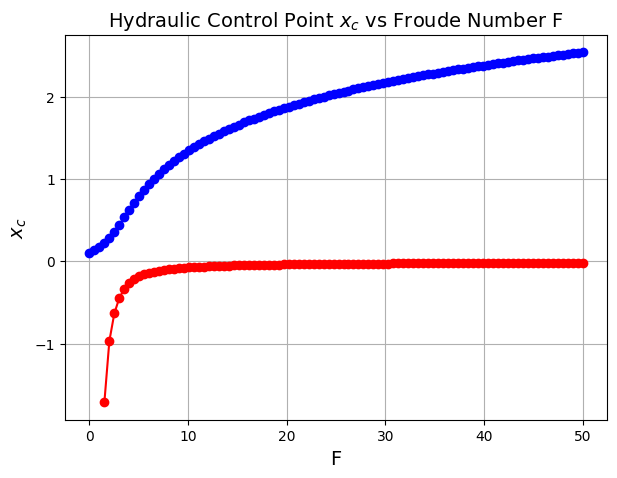

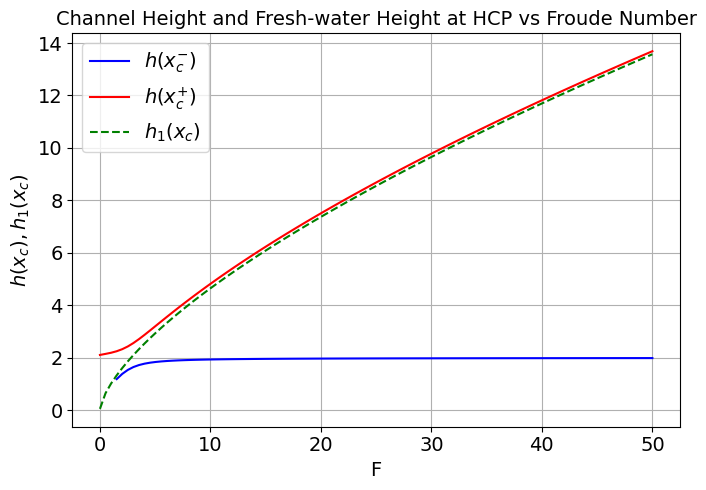

In [ ]:
## Hydraulic control point numerical calculation
import math
import numpy as np
import matplotlib.pyplot as plt

def channel_height(x):
    return 1.0 + np.exp(x)


def compute_x_c(F, S, c):
    """
    Computes the two possible values of x_c from the formula:

      x_c = ln( { (F^(2/3) - S + c) +/- sqrt( (...) ) } / 2 )

    Returns:
      (x_c_plus, x_c_minus)

    If the argument of the log is non-positive, that branch will give an error or a NaN.
    You might need to handle domain checks depending on your parameters.
    """
    # Precompute terms
    f_23 = F**(2/3)  # F^(2/3)
    numerator_base = f_23 - S + c

    # The expression under the sqrt
    inside_sqrt = numerator_base**2 + 4*((f_23 - 1)*(S - 1) + c)

    # Protect against negative inside_sqrt if needed:
    if inside_sqrt < 0:
        # You can decide how to handle no real solutions
        raise ValueError(f"Inside of sqrt is negative ({inside_sqrt}); no real x_c.")

    # Now compute the plus and minus numerators
    root = math.sqrt(inside_sqrt)
    plus_numer = numerator_base + root
    minus_numer = numerator_base - root

    # Each fraction is divided by 2 inside the log
    # Check the sign of each fraction to avoid taking log of a negative/zero
    if plus_numer <= 0:
        x_c_plus = float('nan')  # or handle domain error
    else:
        x_c_plus = math.log(plus_numer / 2)

    if minus_numer <= 0:
        x_c_minus = float('nan')
    else:
        x_c_minus = math.log(minus_numer / 2)

    return x_c_plus, x_c_minus

# Example usage:
if __name__ == "__main__":
    # For example, set parameter values:
    F_val = 1.5
    S_val = 0.0
    c_val = 0.1

    x_c_plus, x_c_minus = compute_x_c(F_val, S_val, c_val)
    print("x_c (plus branch):", x_c_plus)
    print("x_c (minus branch):", x_c_minus)

 # -------------------------------------------------------------------------
    # 1) Now let's sweep over a range of F values and plot x_c vs F
    # -------------------------------------------------------------------------
    F_values = np.linspace(0.01, 50, 100)  # Example sweep from 0.05 to 0.5
    x_c_plus_vals = []
    x_c_minus_vals = []

    # Fix S and c as we vary F:
    S_fixed = 0.0
    c_fixed = 0.1

    for F_ in F_values:
        xcp, xcm = compute_x_c(F_, S_fixed, c_fixed)
        x_c_plus_vals.append(xcp)
        x_c_minus_vals.append(xcm)

    # -------------------------------------------------------------------------
    # 2) Plot x_c^+ and x_c^- as functions of F
    # -------------------------------------------------------------------------
    plt.figure(figsize=(7, 5))
    plt.plot(F_values, x_c_plus_vals, 'bo-', label=r"$x_c^{+}$")
    plt.plot(F_values, x_c_minus_vals, 'ro-', label=r"$x_c^{-}$")
    plt.xlabel("F", fontsize=14)
    plt.ylabel(r"$x_c$", fontsize=14)
    plt.title(r"Hydraulic Control Point $x_c$ vs Froude Number F", fontsize=14)
    plt.grid(True)

    plt.figure(figsize=(7, 5))
    hc_minus = channel_height(x_c_minus_vals)
    hc_minus  = np.array(hc_minus)
    hc_plus = channel_height(x_c_plus_vals)
    hc_plus = np.array(hc_plus)
    plt.plot(F_values, hc_minus, 'b-', label=r"$h(x_c^{-})$")
    plt.plot(F_values, hc_plus, 'r-', label=r"$h(x_c^{+})$")
    h1c = F_values**(2/3)
    plt.plot(F_values, h1c, 'g--', label  = r'$h_1(x_c)$')

    # Axis labels and title with fontsize=14
    plt.xlabel("F", fontsize=14)
    plt.ylabel(r"$h(x_c), h_1(x_c)$", fontsize=14)
    plt.title(r"Channel Height and Fresh-water Height at HCP vs Froude Number", fontsize=14)

    # Make sure all tick labels use fontsize=14
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # Legend with fontsize=14
    plt.legend(fontsize=14)

    plt.grid(True)
    plt.tight_layout()
    plt.show()

Computed ℓ = 1.748212 (so at x = -1.748212, h1 = 1).


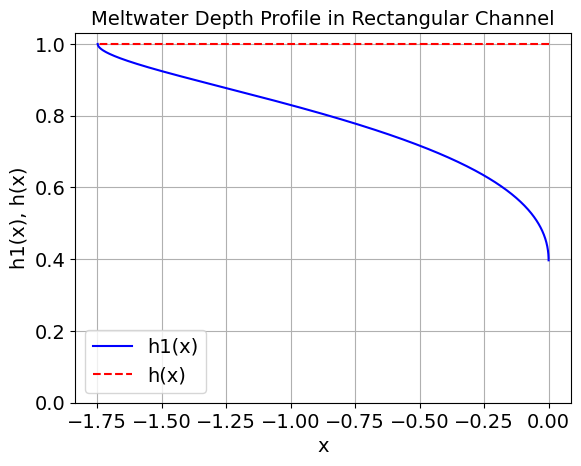

In [ ]:
## rectangular channel model: fresh water profile
import numpy as np
from scipy.integrate import solve_ivp

def compute_l(F, c, S, reltol=1e-8, abstol=1e-10):
    """
    Solve for h1(x) via dx/dh1 = ( (F^2/h1^3) - 1 ) / [ (F^2/h1^3)*(1 + c/(1-h1)) - S ]
    starting from h1 slightly below h0 = F^(2/3), down to h1 = 1.
    Returns:
      x_of_h (OdeResult object), and the final l = -x(h1=1).
    """

    # 1) Boundary condition at x = 0:
    h0 = (F + 0.0001)**(2/3)

    # 2) Define the derivative dx/dh1 = D(h1) / N(h1)
    #    where:
    #      D(h1) = (F^2/h1^3) - 1
    #      N(h1) = (F^2/h1^3)*(1 + c/(1 - h1)) - S
    def dx_dh1(h, x):
        D = (F**2 / h**3) - 1.0
        N = (F**2 / h**3) * (1.0 + c / (1.0 - h)) - S
        return D / N

    # 3) We cannot start exactly at h = h0 because D(h0) = 0 ⇒ dx/dh1 = 0, but the slope is singular.
    #    Instead, pick a very small offset in h:
    eps = 1e-6
    h_start = h0

    # 4) Estimate x_start from a local quadratic expansion around h = h0.  Near h0:
    #      F^2/h^3 - 1 ≈ D'(h0) * (h - h0),  where D'(h0) = d/dh [F^2/h^3] at h0 = -3 F^2 / h0^4.
    #    Also N(h0) = (1)*(1 + c/(1 - h0)) - S  is finite.  So for small Δh = h - h0:
    #      dx/dh ≈ [D'(h0) * (h - h0)] / N(h0).
    #    Hence x(h) - x(h0) ≈ ∫ D'(h0)/N(h0) * (h' - h0) dh' = (D'(h0)/(2 N(h0))) * (h - h0)^2.
    Dprime_at_h0 = -3 * F**2 / (h0**4)
    N_at_h0 = (F**2 / h0**3) * (1.0 + c / (1.0 - h0)) - S
    # Since x(h0) = 0, take:
    x_start = 0 #(Dprime_at_h0 / (2.0 * N_at_h0)) * (h_start - h0)**2

    # 5) Now integrate from h_start down to h_end = 1.0
    h_end = 0.9999

    sol = solve_ivp(
        fun=dx_dh1,
        t_span=(h_start, h_end),
        y0=[x_start],
        rtol=reltol,
        atol=abstol,
        method="RK45",
        dense_output=True,
    )

    # sol.y[0, -1] is x(h=1).  Since we integrated with h decreasing,
    #  x(1) will be negative (or zero).  The coordinate that satisfies h=1 is x = sol.y[0][-1].
    x_when_h_eq1 = sol.y[0, -1]

    # We defined x=0 at h = h0 and integrated downwards, so x(1) = negative =>  -l = x(1) ⇒ l = -x(1).
    ell = -x_when_h_eq1

    return sol, ell

if __name__ == "__main__":
    # Example parameters:
    F = 0.25      # Froude number (choose > 1 so that h0 = F^(2/3) > 1)
    c = 0.1      # some constant
    S = 0      # slope (or another constant)

    sol, l_value = compute_l(F=F, c=c, S=S)

    print(f"Computed ℓ = {l_value:.6f} (so at x = -{l_value:.6f}, h1 = 1).")

    # If you want to see h1(x), you can invert the dense_output:
    # Since sol.sol gives x(h), invert by sampling h at many points and plotting x vs. h.
    import matplotlib.pyplot as plt

    # Create a fine grid in h between h_end=1 and h_start:
    h0 = (F+0.0001)**(2/3)
    h_grid = np.linspace(1.0, h0, 500)
    x_grid = sol.sol(h_grid)[0]
    x_channel = np.linspace(0, -l_value, 500)
    h_channel = np.linspace(1, 1, 500)

    plt.plot(x_grid, h_grid, "b-", label = "h1(x)")
    plt.plot(x_channel, h_channel, "r--", label = "h(x)")
    plt.ylim(bottom=0)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.xlabel("x", fontsize = 14)
    plt.ylabel("h1(x), h(x)", fontsize = 14)
    plt.title("Meltwater Depth Profile in Rectangular Channel", fontsize = 14)
    plt.legend(fontsize = 14)
    plt.grid(True)
    plt.show()


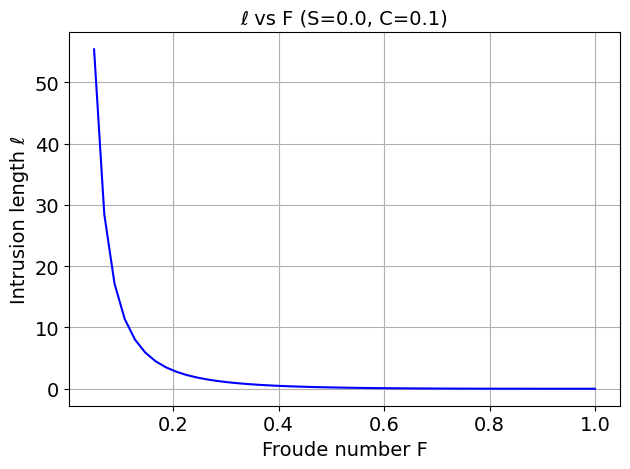

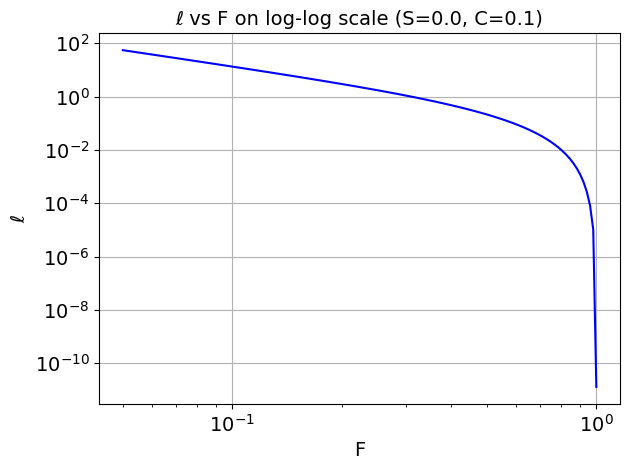

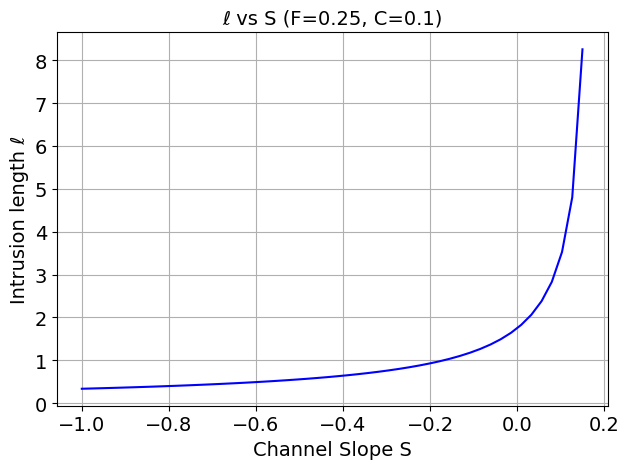

In [ ]:
## Rectangular channel model: intrusion length
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def compute_l(F, c, S, reltol=1e-8, abstol=1e-10):
    """
    Solve for h1(x) via dx/dh1 = ( (F^2/h1^3) - 1 ) / [ (F^2/h1^3)*(1 + c/(1-h1)) - S ]
    starting from h1 slightly below h0 = F^(2/3), down to h1 = 1.
    Returns:
      OdeResult object, and the final l = -x(h1=1).
    """
    h0 = (F+0.0001)**(2/3)

    def dx_dh1(h, x):
        D = (F**2 / h**3) - 1.0
        N = (F**2 / h**3) * (1.0 + c / (1.0 - h)) - S
        return D / N

    h_start = h0

    # Dprime_at_h0 = -3 * F**2 / (h0**4)
    # N_at_h0 = (F**2 / h0**3) * (1.0 + c / (1.0 - h0)) - S
    # x_start = (Dprime_at_h0 / (2.0 * N_at_h0)) * (h_start - h0)**2
    x_start = 0

    h_end = 0.9999

    sol = solve_ivp(
        fun=dx_dh1,
        t_span=(h_start, h_end),
        y0=[x_start],
        rtol=reltol,
        atol=abstol,
        method="RK45",
        dense_output=True,
    )

    x_when_h_eq1 = sol.y[0, -1]
    ell = -x_when_h_eq1
    return sol, ell

if __name__ == "__main__":
    c = 0.1

    # Plot ℓ vs F (with S fixed)
    S_fixed = 0.0
    F_values = np.linspace(0.05, 1, 50)
    l_vs_F = []

    for F in F_values:
        _, ell_val = compute_l(F=F, c=c, S=S_fixed)
        l_vs_F.append(ell_val)

    plt.figure()
    plt.plot(F_values, l_vs_F, "b-")
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.xlabel("Froude number F", fontsize = 14)
    plt.ylabel("Intrusion length ℓ", fontsize = 14)
    plt.title(f"ℓ vs F (S={S_fixed}, C={c})", fontsize = 14)
    plt.grid(True)
    plt.tight_layout()

    plt.figure()
    plt.loglog(F_values, l_vs_F, "b-")
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.xlabel("F", fontsize = 14)
    plt.ylabel("ℓ", fontsize = 14)
    plt.title(f"ℓ vs F on log-log scale (S={S_fixed}, C={c})", fontsize = 14)
    plt.grid(True)
    plt.tight_layout()

    # Plot ℓ vs S (with F fixed)
    F_fixed = 0.25
    S_values = np.linspace(-1.0, 0.15, 50)
    l_vs_S = []

    for S in S_values:
        _, ell_val = compute_l(F=F_fixed, c=c, S=S)
        l_vs_S.append(ell_val)

    plt.figure()
    plt.plot(S_values, l_vs_S, "b-")
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.xlabel("Channel Slope S", fontsize = 14)
    plt.ylabel("Intrusion length ℓ", fontsize = 14)
    plt.title(f"ℓ vs S (F={F_fixed}, C={c})", fontsize = 14)
    plt.grid(True)
    plt.tight_layout()


Solution found up to x = -1.7422 => l = 1.7422


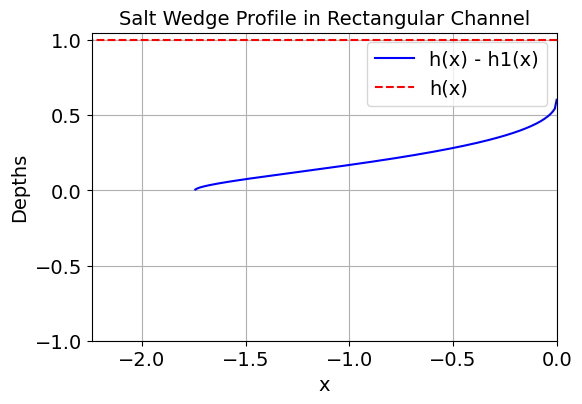

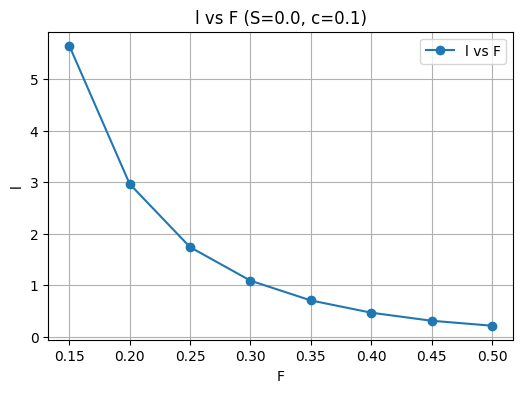

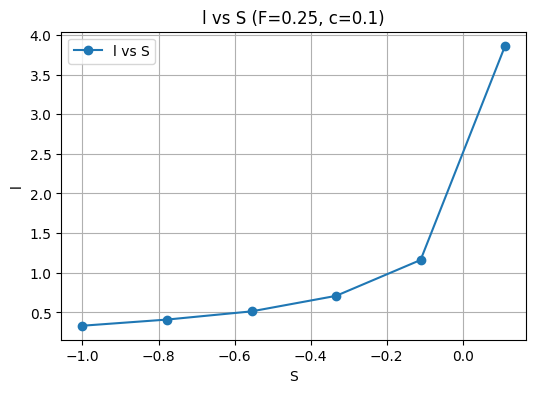

In [ ]:
## rectangular channel model: alternative method
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def channel_height(x):
    """
    Prescribed channel shape h(x) = 1 + e^x.
    Valid for x in (-∞, 0].
    """
    return 1.0

def dhdx(x):
    """
    Derivative of h(x) with respect to x.
    For h(x) = 1 + e^x, dh/dx = e^x.
    """
    return 0

def ode_system(x, h1, F, S, c):
    """
    Right-hand side of the ODE:
      ( (F^2)/(h1^3) - 1 ) * dh1/dx = (F^2)/(h1^3) [1 + c*(h/(h - h1)) ] - [S + dh/dx]
    => dh1/dx = { (F^2)/(h1^3) [1 + c*(h/(h - h1)) ] - [S + dh/dx] } / { (F^2)/(h1^3) - 1 }

    x   : spatial position
    h1  : the unknown function h1(x)
    F   : Froude number
    S   : slope parameter
    c   : given constant
    """
    h = channel_height(x)
    dhdx_val = dhdx(x)

    numerator = (F**2 / h1**3) * (1 + c * h / (h - h1)) - (S + dhdx_val)
    denominator = (F**2 / h1**3) - 1.0

    # Avoid dividing by zero in practice, so handle carefully if the solution is near the singularity.
    return numerator / denominator

def event_h1_equals_h(x, y, F, S, c):
    """
    Event function for solve_ivp to stop when h1(x) == h(x).
    We define the zero-crossing to be h1 - h = 0.
    """
    h = channel_height(x)
    return y[0] - (h - 0.006) # the stopping condition is h1 = h , but shifted slightly to avoid singularity in the ODE

# We want the solver to stop when h1 == h:
event_h1_equals_h.terminal = True   # Stop integration
event_h1_equals_h.direction = 0     # Detect all zero-crossings

def solve_h1(F, S, c,
             x_start= 0,
             x_end=-10):
    """
    Solve the ODE from x_start down to x_end (negative direction),
    with an initial guess for h1 near F^(2/3).
    Once h1 = h is reached, the solver stops by the event.

    Returns:
      sol       : the ODE solution object from solve_ivp
      x_stop    : where the event h1-h=0 occurs (i.e., x = -l)
      h1_stop   : h1 at that point (should equal h)
    """
    # The exact boundary condition is h1(0) = F^(2/3).
    # To avoid singularity, we start from x_start < 0 with h1 ~ F^(2/3).
    h1_boundary = (F + 0.0001)**(2.0/3.0)

    # Optionally shift the initial h1 by a tiny offset if desired,
    # though you can also just keep it exactly h1_boundary.
    y0 = [h1_boundary]  # or [h1_boundary + h1_start_offset]

    # We'll integrate from x_start to x_end. Because x_start > x_end,
    # the solver automatically goes "backwards" in x.
    sol = solve_ivp(
        fun=lambda xx, yy: ode_system(xx, yy[0], F, S, c),
        t_span=(x_start, x_end),
        y0=y0,
        events=lambda xx, yy: event_h1_equals_h(xx, yy, F, S, c),
        dense_output=True,  # so we can evaluate anywhere
        max_step=1e-2       # limit step size if needed
    )

    # Check if the event was triggered:
    if sol.t_events[0].size > 0:
        x_stop = sol.t_events[0][0]
        # Evaluate h1 at x_stop:
        h1_stop = sol.sol(x_stop)[0]
    else:
        # No event triggered => h1 might never equal h within x_start..x_end
        x_stop = None
        h1_stop = None

    return sol, x_stop, h1_stop

def example_single_solution_plot():
    """
    Example of solving and plotting h1(x) vs x for a single set of parameters.
    Also prints the computed l = -x_stop.
    """
    F = 0.25
    S = 0.0
    c = 0.1

    sol, x_stop, h1_stop = solve_h1(F, S, c)

    if x_stop is not None:
        l_val = -x_stop  # since x_stop = -l
        print(f"Solution found up to x = {x_stop:.4f} => l = {l_val:.4f}")
    else:
        print("No crossing event found where h1 = h in the interval.")

    # Plot h1 vs x along the solution
    plt.figure(figsize=(6,4))
    x_vals = np.linspace(0, x_stop, 200)
    x_vals1 = np.linspace(0, x_stop - 0.5, 200)
    height_of_channel = np.linspace(1, 1, 200)
    h1_plot = sol.sol(x_vals)[0]
    # plt.plot(x_vals, h1_plot, 'b-', label='h1(x)')
    plt.plot(x_vals, channel_height(x_vals) - h1_plot, 'b-', label= 'h(x) - h1(x)')
    # Also plot the channel shape h(x) for reference
    plt.plot(x_vals1, height_of_channel, 'r--', label='h(x)')
    plt.xlim(left = x_stop -0.5, right = 0)
    plt.ylim(bottom=-1)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.xlabel('x', fontsize = 14)
    plt.ylabel('Depths', fontsize = 14)
    plt.title(f'Salt Wedge Profile in Rectangular Channel', fontsize = 14)
    plt.legend(fontsize = 14)
    plt.grid(True)
    plt.show()

def sweep_F_values():
    """
    Example of sweeping over a range of F values and finding the corresponding l.
    Plots l against F.
    """
    F_values = np.linspace(0.05, 0.5, 10)  # for example
    S = 0.0
    c = 0.1

    L_values = []
    for F in F_values:
        sol, x_stop, h1_stop = solve_h1(F, S, c)
        if x_stop is not None:
            L_values.append(-x_stop)
        else:
            # If no crossing found, store NaN or some sentinel
            L_values.append(np.nan)

    plt.figure(figsize=(6,4))
    plt.plot(F_values, L_values, 'o-', label='l vs F')
    plt.xlabel('F')
    plt.ylabel('l')
    plt.title(f'l vs F (S={S}, c={c})')
    plt.grid(True)
    plt.legend()
    plt.show()

def sweep_S_values():
    """
    Example of sweeping over a range of S values and finding l.
    Plots l against S.
    """
    S_values = np.linspace(-1.0, 1.0, 10)  # for example
    F = 0.25
    c = 0.1

    L_values = []
    for S in S_values:
        sol, x_stop, h1_stop = solve_h1(F, S, c)
        if x_stop is not None:
            L_values.append(-x_stop)
        else:
            L_values.append(np.nan)

    plt.figure(figsize=(6,4))
    plt.plot(S_values, L_values, 'o-', label='l vs S')
    plt.xlabel('S')
    plt.ylabel('l')
    plt.title(f'l vs S (F={F}, c={c})')
    plt.grid(True)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    # 1) Solve once for a single set of parameters and plot h1(x) vs x
    example_single_solution_plot()

    # 2) Sweep over F and plot l(F)
    sweep_F_values()

    # 3) Sweep over S and plot l(S)
    sweep_S_values()

Solution found up to x = -4.2080 => l = 4.2080


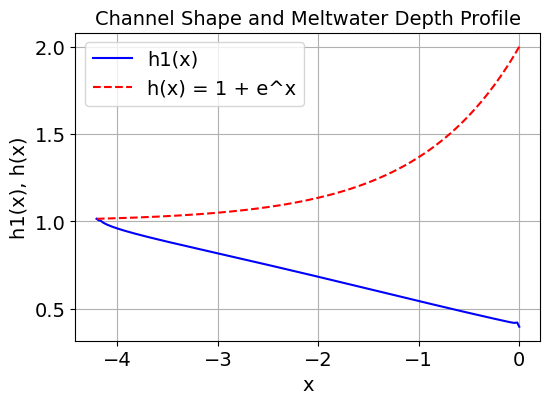

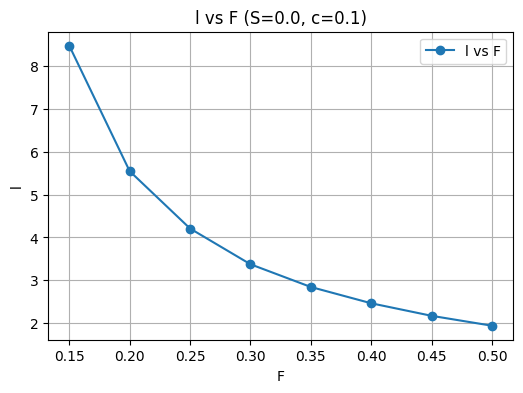

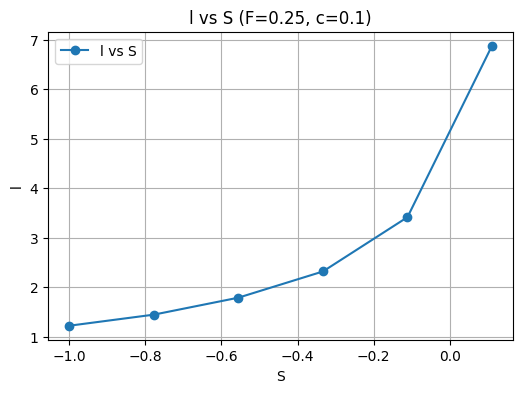

In [ ]:
## Ice sheet with prescribed shape: HCP at mouth of channel (x = 0)
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def channel_height(x):
    """
    Prescribed channel shape h(x) = 1 + e^x.
    Valid for x in (-∞, 0].
    """
    return 1.0 + np.exp(x)

def dhdx(x):
    """
    Derivative of h(x) with respect to x.
    For h(x) = 1 + e^x, dh/dx = e^x.
    """
    return np.exp(x)

def ode_system(x, h1, F, S, c):
    """
    Right-hand side of the ODE:
      ( (F^2)/(h1^3) - 1 ) * dh1/dx = (F^2)/(h1^3) [1 + c*(h/(h - h1)) ] - [S + dh/dx]
    => dh1/dx = { (F^2)/(h1^3) [1 + c*(h/(h - h1)) ] - [S + dh/dx] } / { (F^2)/(h1^3) - 1 }

    x   : spatial position
    h1  : the unknown function h1(x)
    F   : Froude number
    S   : slope parameter
    c   : given constant
    """
    h = channel_height(x)
    dhdx_val = dhdx(x)

    numerator = (F**2 / h1**3) * (1 + c * h / (h - h1)) - (S + dhdx_val)
    denominator = (F**2 / h1**3) - 1.0

    # Avoid dividing by zero in practice, so handle carefully if the solution is near the singularity.
    return numerator / denominator

def event_h1_equals_h(x, y, F, S, c):
    """
    Event function for solve_ivp to stop when h1(x) == h(x).
    We define the zero-crossing to be h1 - h = 0.
    """
    h = channel_height(x)
    return y[0] - h

# We want the solver to stop when h1 == h:
event_h1_equals_h.terminal = True   # Stop integration
event_h1_equals_h.direction = 0     # Detect all zero-crossings

def solve_h1(F, S, c,
             x_start= 0,
             x_end=-10):
    """
    Solve the ODE from x_start down to x_end (negative direction),
    with an initial guess for h1 near F^(2/3).
    Once h1 = h is reached, the solver stops by the event.

    Returns:
      sol       : the ODE solution object from solve_ivp
      x_stop    : where the event h1-h=0 occurs (i.e., x = -l)
      h1_stop   : h1 at that point (should equal h)
    """
    # The exact boundary condition is h1(0) = F^(2/3).
    # To avoid singularity, we start from x_start < 0 with h1 ~ F^(2/3).
    h1_boundary = (F + 0.0001)**(2.0/3.0)

    # Optionally shift the initial h1 by a tiny offset if desired,
    # though you can also just keep it exactly h1_boundary.
    y0 = [h1_boundary]  # or [h1_boundary + h1_start_offset]

    # We'll integrate from x_start to x_end. Because x_start > x_end,
    # the solver automatically goes "backwards" in x.
    sol = solve_ivp(
        fun=lambda xx, yy: ode_system(xx, yy[0], F, S, c),
        t_span=(x_start, x_end),
        y0=y0,
        events=lambda xx, yy: event_h1_equals_h(xx, yy, F, S, c),
        dense_output=True,  # so we can evaluate anywhere
        max_step=1e-2       # limit step size if needed
    )

    # Check if the event was triggered:
    if sol.t_events[0].size > 0:
        x_stop = sol.t_events[0][0]
        # Evaluate h1 at x_stop:
        h1_stop = sol.sol(x_stop)[0]
    else:
        # No event triggered => h1 might never equal h within x_start..x_end
        x_stop = None
        h1_stop = None

    return sol, x_stop, h1_stop

def example_single_solution_plot():
    """
    Example of solving and plotting h1(x) vs x for a single set of parameters.
    Also prints the computed l = -x_stop.
    """
    F = 0.25
    S = 0.0
    c = 0.1

    sol, x_stop, h1_stop = solve_h1(F, S, c)

    if x_stop is not None:
        l_val = -x_stop  # since x_stop = -l
        print(f"Solution found up to x = {x_stop:.4f} => l = {l_val:.4f}")
    else:
        print("No crossing event found where h1 = h in the interval.")

    # Plot h1 vs x along the solution
    plt.figure(figsize=(6,4))
    x_vals = np.linspace(0, x_stop, 200)
    h1_plot = sol.sol(x_vals)[0]
    plt.plot(x_vals, h1_plot, 'b-', label='h1(x)')
    # Also plot the channel shape h(x) for reference
    plt.plot(x_vals, channel_height(x_vals), 'r--', label='h(x) = 1 + e^x')
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.xlabel('x', fontsize = 14)
    plt.ylabel('h1(x), h(x)', fontsize = 14)
    plt.title(f'Channel Shape and Meltwater Depth Profile', fontsize = 14)
    plt.legend(fontsize = 14)
    plt.grid(True)
    plt.show()

def sweep_F_values():
    """
    Example of sweeping over a range of F values and finding the corresponding l.
    Plots l against F.
    """
    F_values = np.linspace(0.05, 0.5, 10)  # for example
    S = 0.0
    c = 0.1

    L_values = []
    for F in F_values:
        sol, x_stop, h1_stop = solve_h1(F, S, c)
        if x_stop is not None:
            L_values.append(-x_stop)
        else:
            # If no crossing found, store NaN or some sentinel
            L_values.append(np.nan)

    plt.figure(figsize=(6,4))
    plt.plot(F_values, L_values, 'o-', label='l vs F')
    plt.xlabel('F')
    plt.ylabel('l')
    plt.title(f'l vs F (S={S}, c={c})')
    plt.grid(True)
    plt.legend()
    plt.show()

def sweep_S_values():
    """
    Example of sweeping over a range of S values and finding l.
    Plots l against S.
    """
    S_values = np.linspace(-1.0, 1.0, 10)  # for example
    F = 0.25
    c = 0.1

    L_values = []
    for S in S_values:
        sol, x_stop, h1_stop = solve_h1(F, S, c)
        if x_stop is not None:
            L_values.append(-x_stop)
        else:
            L_values.append(np.nan)

    plt.figure(figsize=(6,4))
    plt.plot(S_values, L_values, 'o-', label='l vs S')
    plt.xlabel('S')
    plt.ylabel('l')
    plt.title(f'l vs S (F={F}, c={c})')
    plt.grid(True)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    # 1) Solve once for a single set of parameters and plot h1(x) vs x
    example_single_solution_plot()

    # 2) Sweep over F and plot l(F)
    sweep_F_values()

    # 3) Sweep over S and plot l(S)
    sweep_S_values()

Solution found up to x = -4.1750 => l = 4.1750


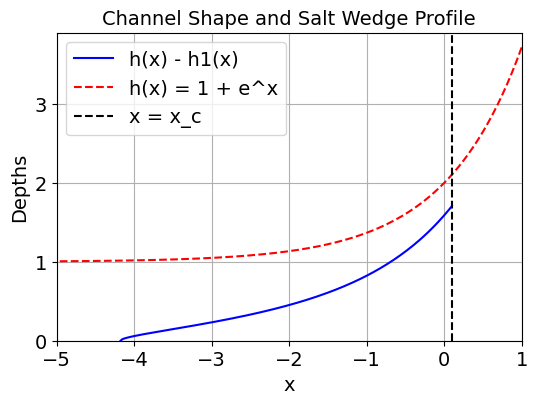

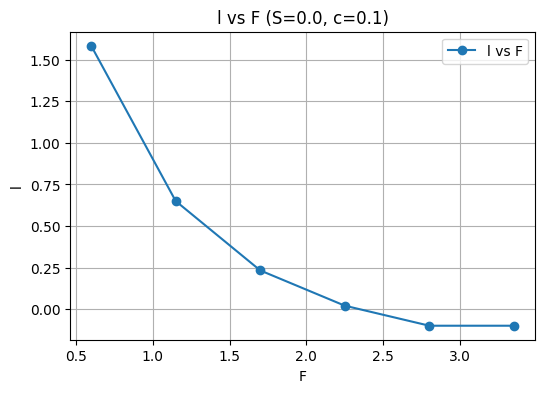

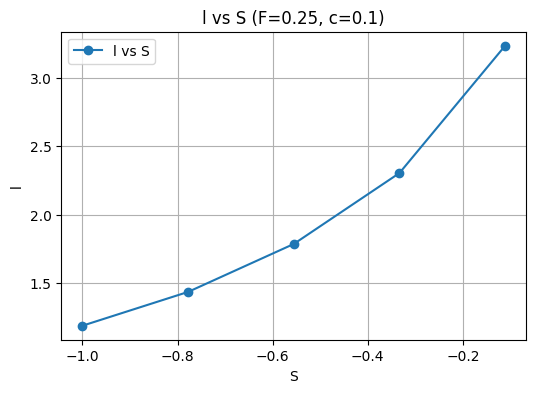

In [ ]:
## Ice sheet with prescribed shape: HCP from calculation (x = x_c)
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def channel_height(x):
    """
    Prescribed channel shape h(x) = 1 + e^x.
    Valid for x in (-∞, 0].
    """
    return 1.0 + np.exp(x)

def dhdx(x):
    """
    Derivative of h(x) with respect to x.
    For h(x) = 1 + e^x, dh/dx = e^x.
    """
    return np.exp(x)

def ode_system(x, h1, F, S, c):
    """
    Right-hand side of the ODE:
      ( (F^2)/(h1^3) - 1 ) * dh1/dx = (F^2)/(h1^3) [1 + c*(h/(h - h1)) ] - [S + dh/dx]
    => dh1/dx = { (F^2)/(h1^3) [1 + c*(h/(h - h1)) ] - [S + dh/dx] } / { (F^2)/(h1^3) - 1 }

    x   : spatial position
    h1  : the unknown function h1(x)
    F   : Froude number
    S   : slope parameter
    c   : given constant
    """
    h = channel_height(x)
    dhdx_val = dhdx(x)

    numerator = (F**2 / h1**3) * (1 + c * h / (h - h1)) - (S + dhdx_val)
    denominator = (F**2 / h1**3) - 1.0

    # Avoid dividing by zero in practice, so handle carefully if the solution is near the singularity.
    return numerator / denominator

def event_h1_equals_h(x, y, F, S, c):
    """
    Event function for solve_ivp to stop when h1(x) == h(x).
    We define the zero-crossing to be h1 - h = 0.
    """
    h = channel_height(x)
    return y[0] - h

# We want the solver to stop when h1 == h:
event_h1_equals_h.terminal = True   # Stop integration
event_h1_equals_h.direction = 0     # Detect all zero-crossings

def solve_h1(F, S, c,
             x_start=0.1,
             x_end=-100):
    """
    Solve the ODE from x_start down to x_end (negative direction),
    with an initial guess for h1 near F^(2/3).
    Once h1 = h is reached, the solver stops by the event.

    Returns:
      sol       : the ODE solution object from solve_ivp
      x_stop    : where the event h1-h=0 occurs (i.e., x = -l)
      h1_stop   : h1 at that point (should equal h)
    """
    # The exact boundary condition is h1(0) = F^(2/3).
    # To avoid singularity, we start from x_start < 0 with h1 ~ F^(2/3).
    h1_boundary = (F + 0.0001)**(2.0/3.0)

    # Optionally shift the initial h1 by a tiny offset if desired,
    # though you can also just keep it exactly h1_boundary.
    y0 = [h1_boundary]  # or [h1_boundary + h1_start_offset]

    # We'll integrate from x_start to x_end. Because x_start > x_end,
    # the solver automatically goes "backwards" in x.
    sol = solve_ivp(
        fun=lambda xx, yy: ode_system(xx, yy[0], F, S, c),
        t_span=(x_start, x_end),
        y0=y0,
        events=lambda xx, yy: event_h1_equals_h(xx, yy, F, S, c),
        dense_output=True,  # so we can evaluate anywhere
        max_step=1e-2       # limit step size if needed
    )

    # Check if the event was triggered:
    if sol.t_events[0].size > 0:
        x_stop = sol.t_events[0][0]
        # Evaluate h1 at x_stop:
        h1_stop = sol.sol(x_stop)[0]
    else:
        # No event triggered => h1 might never equal h within x_start..x_end
        x_stop = None
        h1_stop = None

    return sol, x_stop, h1_stop

def example_single_solution_plot():
    """
    Example of solving and plotting h1(x) vs x for a single set of parameters.
    Also prints the computed l = -x_stop.
    """
    F = 0.25
    S = 0.0
    c = 0.1

    sol, x_stop, h1_stop = solve_h1(F, S, c)

    if x_stop is not None:
        l_val = - x_stop
        print(f"Solution found up to x = {x_stop:.4f} => l = {l_val:.4f}")
    else:
        print("No crossing event found where h1 = h in the interval.")


    # Plot h1 vs x along the solution
    plt.figure(figsize=(6,4))
    x_vals = np.linspace(0.1, x_stop, 200)
    h1_plot = sol.sol(x_vals)[0]
    # plt.plot(x_vals, h1_plot, 'b-', label='h1(x)')
    plt.plot(x_vals, channel_height(x_vals) - h1_plot, 'b-', label='h(x) - h1(x)')
    # Also plot the channel shape h(x) for reference
    x_vals1 = np.linspace(1, x_stop - 1, 200)
    plt.plot(x_vals1, channel_height(x_vals1), 'r--', label='h(x) = 1 + e^x')
    plt.axvline(x=0.1, color='k', linestyle='--', label='x = x_c')
    plt.xlim(left = -5, right = 1)
    plt.ylim(bottom=0)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.xlabel('x', fontsize =14)
    plt.ylabel('Depths', fontsize =14)
    plt.title(f'Channel Shape and Salt Wedge Profile', fontsize =14)
    plt.legend(fontsize =14)
    plt.grid(True)
    plt.show()

def sweep_F_values():
    """
    Example of sweeping over a range of F values and finding the corresponding l.
    Plots l against F.
    """
    F_values = np.linspace(0.05, 5, 10)  # for example
    S = 0.0
    c = 0.1

    L_values = []
    for F in F_values:
        sol, x_stop, h1_stop = solve_h1(F, S, c)
        if x_stop is not None:
            L_values.append(-x_stop)
        else:
            # If no crossing found, store NaN or some sentinel
            L_values.append(np.nan)

    plt.figure(figsize=(6,4))
    plt.plot(F_values, L_values, 'o-', label='l vs F')
    plt.xlabel('F')
    plt.ylabel('l')
    plt.title(f'l vs F (S={S}, c={c})')
    plt.grid(True)
    plt.legend()
    plt.show()

def sweep_S_values():
    """
    Example of sweeping over a range of S values and finding l.
    Plots l against S.
    """
    S_values = np.linspace(-1.0, 1.0, 10)  # for example
    F = 0.25
    c = 0.1

    L_values = []
    for S in S_values:
        sol, x_stop, h1_stop = solve_h1(F, S, c)
        if x_stop is not None:
            L_values.append(-x_stop)
        else:
            L_values.append(np.nan)

    plt.figure(figsize=(6,4))
    plt.plot(S_values, L_values, 'o-', label='l vs S')
    plt.xlabel('S')
    plt.ylabel('l')
    plt.title(f'l vs S (F={F}, c={c})')
    plt.grid(True)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    # 1) Solve once for a single set of parameters and plot h1(x) vs x
    example_single_solution_plot()

    # 2) Sweep over F and plot l(F)
    sweep_F_values()

    # 3) Sweep over S and plot l(S)
    sweep_S_values()

Solution found up to x = -4.1757 => l = 4.2917


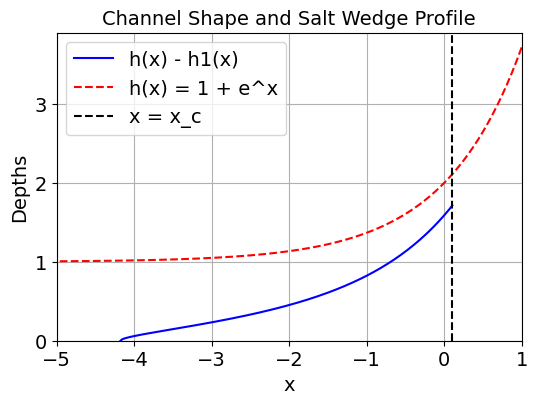

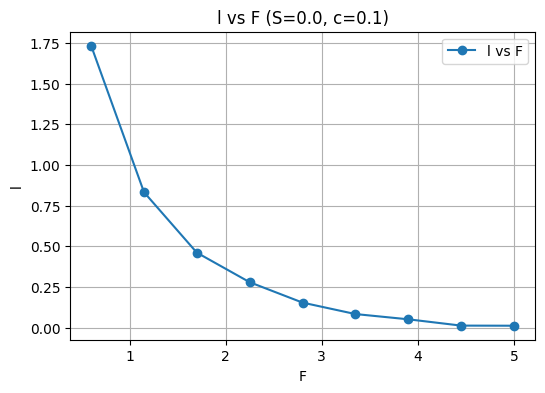

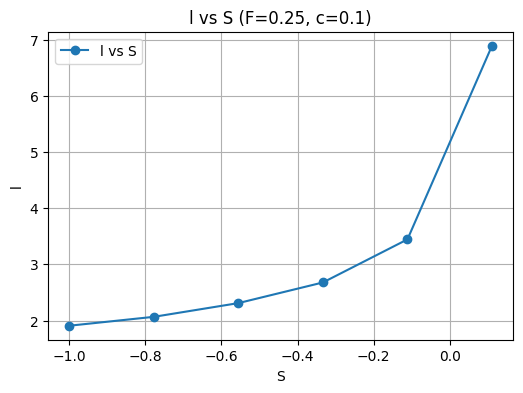

In [ ]:
## Ice sheet with prescribed shape: HCP from calculation (x = x_c)
## Updated intrusion length = x_c - x_l
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def channel_height(x):
    """
    Prescribed channel shape h(x) = 1 + e^x.
    Valid for x in (-∞, 0].
    """
    return 1.0 + np.exp(x)

def dhdx(x):
    """
    Derivative of h(x) with respect to x.
    For h(x) = 1 + e^x, dh/dx = e^x.
    """
    return np.exp(x)

def ode_system(x, h1, F, S, c):
    """
    Right-hand side of the ODE:
      ( (F^2)/(h1^3) - 1 ) * dh1/dx = (F^2)/(h1^3) [1 + c*(h/(h - h1)) ] - [S + dh/dx]
    => dh1/dx = { (F^2)/(h1^3) [1 + c*(h/(h - h1)) ] - [S + dh/dx] } / { (F^2)/(h1^3) - 1 }

    x   : spatial position
    h1  : the unknown function h1(x)
    F   : Froude number
    S   : slope parameter
    c   : given constant
    """
    h = channel_height(x)
    dhdx_val = dhdx(x)

    numerator = (F**2 / h1**3) * (1 + c * h / (h - h1)) - (S + dhdx_val)
    denominator = (F**2 / h1**3) - 1.0

    # Avoid dividing by zero in practice, so handle carefully if the solution is near the singularity.
    return numerator / denominator

def event_h1_equals_h(x, y, F, S, c):
    """
    Event function for solve_ivp to stop when h1(x) == h(x).
    We define the zero-crossing to be h1 - h = 0.
    """
    h = channel_height(x)
    return y[0] - h

# We want the solver to stop when h1 == h:
event_h1_equals_h.terminal = True   # Stop integration
event_h1_equals_h.direction = 0     # Detect all zero-crossings

def solve_h1(F, S, c,
             x_end=-100):
    """
    Solve the ODE from x_start down to x_end (negative direction),
    with an initial guess for h1 near F^(2/3).
    Once h1 = h is reached, the solver stops by the event.

    Returns:
      sol       : the ODE solution object from solve_ivp
      x_stop    : where the event h1-h=0 occurs (i.e., x = -l)
      h1_stop   : h1 at that point (should equal h)
    """
    # The exact boundary condition is h1(0) = F^(2/3).
    # To avoid singularity, we start from x_start < 0 with h1 ~ F^(2/3).
    h1_boundary = (F + 0.0001)**(2.0/3.0)

    # Optionally shift the initial h1 by a tiny offset if desired,
    # though you can also just keep it exactly h1_boundary.
    y0 = [h1_boundary]  # or [h1_boundary + h1_start_offset]

    x_c_plus, x_c_minus = compute_x_c(F, S, c)
    x_start = x_c_plus - 0.01

    # We'll integrate from x_start to x_end. Because x_start > x_end,
    # the solver automatically goes "backwards" in x.
    sol = solve_ivp(
        fun=lambda xx, yy: ode_system(xx, yy[0], F, S, c),
        t_span=(x_start, x_end),
        y0=y0,
        events=lambda xx, yy: event_h1_equals_h(xx, yy, F, S, c),
        dense_output=True,  # so we can evaluate anywhere
        max_step=1e-2       # limit step size if needed
    )

    # Check if the event was triggered:
    if sol.t_events[0].size > 0:
        x_stop = sol.t_events[0][0]
        # Evaluate h1 at x_stop:
        h1_stop = sol.sol(x_stop)[0]
    else:
        # No event triggered => h1 might never equal h within x_start..x_end
        x_stop = None
        h1_stop = None

    return sol, x_stop, h1_stop

def example_single_solution_plot():
    """
    Example of solving and plotting h1(x) vs x for a single set of parameters.
    Also prints the computed l = -x_stop.
    """
    F = 0.25
    S = 0.0
    c = 0.1

    sol, x_stop, h1_stop = solve_h1(F, S, c)
    x_c_plus, x_c_minus = compute_x_c(F, S, c)
    if x_stop is not None:
        l_val = x_c_plus - x_stop
        print(f"Solution found up to x = {x_stop:.4f} => l = {l_val:.4f}")
    else:
        print("No crossing event found where h1 = h in the interval.")


    # Plot h1 vs x along the solution
    plt.figure(figsize=(6,4))
    x_vals = np.linspace(x_c_plus - 0.01, x_stop, 200)
    h1_plot = sol.sol(x_vals)[0]
    # plt.plot(x_vals, h1_plot, 'b-', label='h1(x)')
    plt.plot(x_vals, channel_height(x_vals) - h1_plot, 'b-', label='h(x) - h1(x)')
    # Also plot the channel shape h(x) for reference
    x_vals1 = np.linspace(1, x_stop - 1, 200)
    plt.plot(x_vals1, channel_height(x_vals1), 'r--', label='h(x) = 1 + e^x')
    plt.axvline(x=0.1, color='k', linestyle='--', label='x = x_c')
    plt.xlim(left = -5, right = 1)
    plt.ylim(bottom=0)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.xlabel('x', fontsize =14)
    plt.ylabel('Depths', fontsize =14)
    plt.title(f'Channel Shape and Salt Wedge Profile', fontsize =14)
    plt.legend(fontsize =14)
    plt.grid(True)
    plt.show()

def sweep_F_values():
    """
    Example of sweeping over a range of F values and finding the corresponding l.
    Plots l against F.
    """
    F_values = np.linspace(0.05, 5, 10)  # for example
    S = 0.0
    c = 0.1

    L_values = []
    for F in F_values:
        x_c_plus, x_c_minus = compute_x_c(F, S, c)
        sol, x_stop, h1_stop = solve_h1(F, S, c)
        if x_stop is not None:
            L_values.append(x_c_plus - x_stop)
        else:
            # If no crossing found, store NaN or some sentinel
            L_values.append(np.nan)

    plt.figure(figsize=(6,4))
    plt.plot(F_values, L_values, 'o-', label='l vs F')
    plt.xlabel('F')
    plt.ylabel('l')
    plt.title(f'l vs F (S={S}, c={c})')
    plt.grid(True)
    plt.legend()
    plt.show()

def sweep_S_values():
    """
    Example of sweeping over a range of S values and finding l.
    Plots l against S.
    """
    S_values = np.linspace(-1.0, 1.0, 10)  # for example
    F = 0.25
    c = 0.1

    L_values = []
    for S in S_values:
        x_c_plus, x_c_minus = compute_x_c(F, S, c)
        sol, x_stop, h1_stop = solve_h1(F, S, c)
        if x_stop is not None:
            L_values.append(x_c_plus - x_stop)
        else:
            L_values.append(np.nan)

    plt.figure(figsize=(6,4))
    plt.plot(S_values, L_values, 'o-', label='l vs S')
    plt.xlabel('S')
    plt.ylabel('l')
    plt.title(f'l vs S (F={F}, c={c})')
    plt.grid(True)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    # 1) Solve once for a single set of parameters and plot h1(x) vs x
    example_single_solution_plot()

    # 2) Sweep over F and plot l(F)
    sweep_F_values()

    # 3) Sweep over S and plot l(S)
    sweep_S_values()